In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm, notebook,trange
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import recall_score as rec_score
from sklearn.metrics import precision_score as prec_score
from sklearn.metrics import f1_score as f_scores
from sklearn.metrics import confusion_matrix 

In [3]:
from keras import backend as K
from keras.applications import ResNet50,VGG19,VGG16,Xception,InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten,BatchNormalization
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
import plotly as px
import plotly.graph_objects as go

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
plt.style.use('fivethirtyeight')

import warnings 
warnings.filterwarnings(action="ignore")

In [5]:
train_data = pd.read_csv("../input/common-voice/cv-valid-train.csv")

In [6]:
train_data.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


In [7]:
train_data = train_data[["filename","age","gender","accent"]]

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195776 entries, 0 to 195775
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  195776 non-null  object
 1   age       73768 non-null   object
 2   gender    74059 non-null   object
 3   accent    64711 non-null   object
dtypes: object(4)
memory usage: 6.0+ MB


In [9]:
train_data.dropna(inplace=True)
train_data.reset_index(inplace=True)
train_data.drop("index",axis=1,inplace=True)

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63163 entries, 0 to 63162
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  63163 non-null  object
 1   age       63163 non-null  object
 2   gender    63163 non-null  object
 3   accent    63163 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


# Visualisation

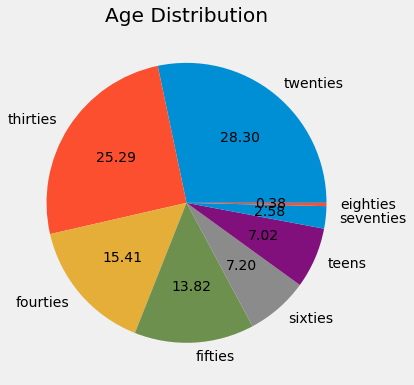

In [11]:
plt.title("Age Distribution")
plt.pie(train_data.age.value_counts().values,labels=train_data.age.value_counts().index,autopct="%0.2f")
plt.show()

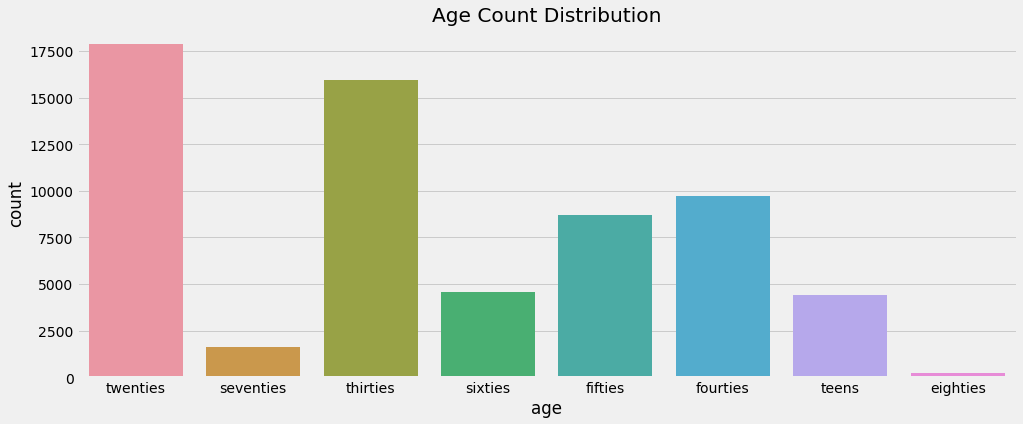

In [12]:
plt.title("Age Count Distribution")
sns.countplot(x=train_data.age)
plt.show()

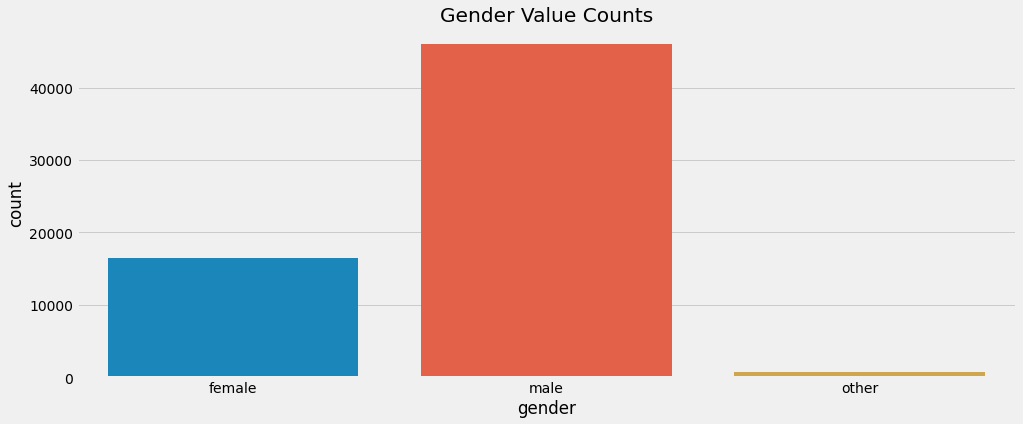

In [13]:
plt.title("Gender Value Counts")
sns.countplot(x=train_data.gender)
plt.show()

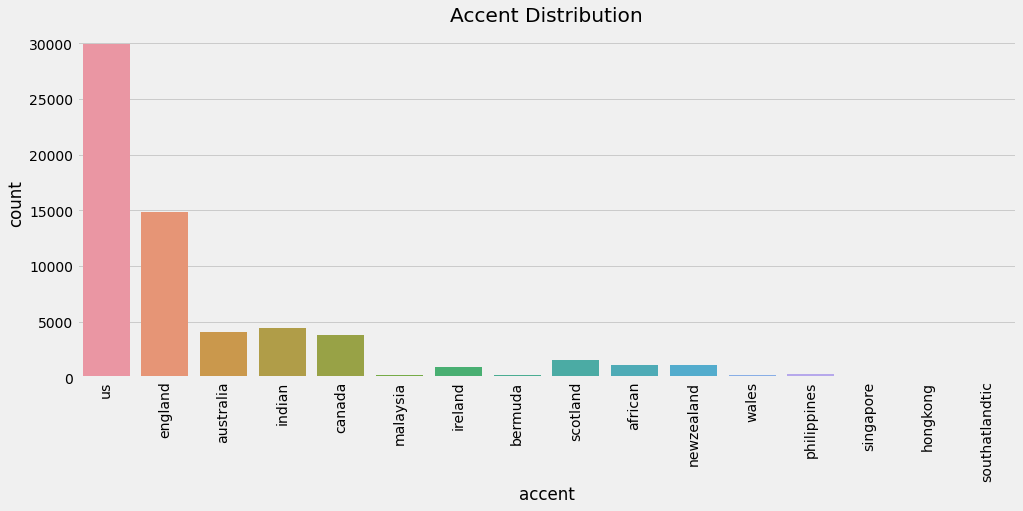

In [14]:
plt.title("Accent Distribution")
sns.countplot(x=train_data.accent)
plt.xticks(rotation=90)
plt.show()

In [15]:
accent_to_keep = train_data.accent.value_counts().index[0:9]

idx = []
for i in range(train_data.shape[0]):
    if train_data.accent[i] in accent_to_keep:
        idx.append(i)

In [16]:
train_data = train_data.loc[idx]
train_data.reset_index(inplace=True)
train_data.drop("index",axis=1,inplace=True)

# Visualizing some features of Audio wave

In [17]:
voice_dir = "../input/common-voice/cv-valid-train"
sample_rate = 16000

In [18]:
# Taking Random voice sample
idx = np.random.randint(0,len(train_data))
# storing idx'th voice fiel name
filename = voice_dir +"/"+train_data.filename[idx]


### Audio Wave

<Figure size 864x216 with 0 Axes>

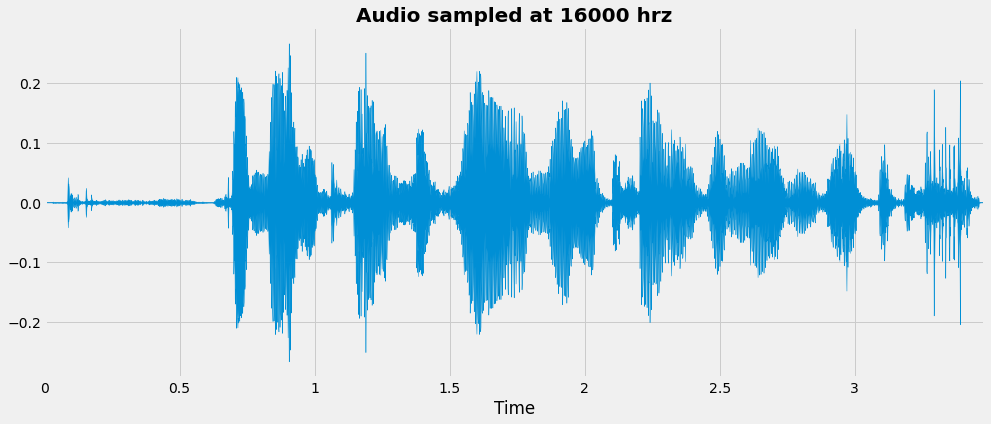

In [19]:
# Loading audio sample
audio_array, sampling_rate = librosa.load(filename, sr=sample_rate)
# Creating figure
plt.figure(figsize=(12, 3))
plt.figure()
librosa.display.waveplot(audio_array, sr=sampling_rate)
plt.title('Audio sampled at {} hrz'.format(sample_rate),fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.show()

### Mel-Frequency Cepstral Coefficient

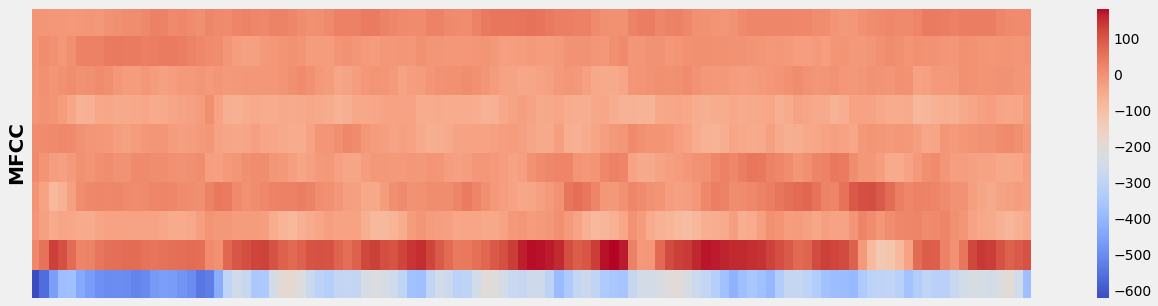

In [20]:
# Loading Audio sample
audio_array,sampling_rate = librosa.load(filename, sr=sample_rate) 
# MFCC with 10 components
mfcc = librosa.feature.mfcc(y=audio_array, sr=sample_rate, n_mfcc = 10) 

plt.figure(figsize=(20,5))
librosa.display.specshow(mfcc)
plt.ylabel('MFCC',fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.colorbar()
plt.show()

###  Log Mel-spectogram

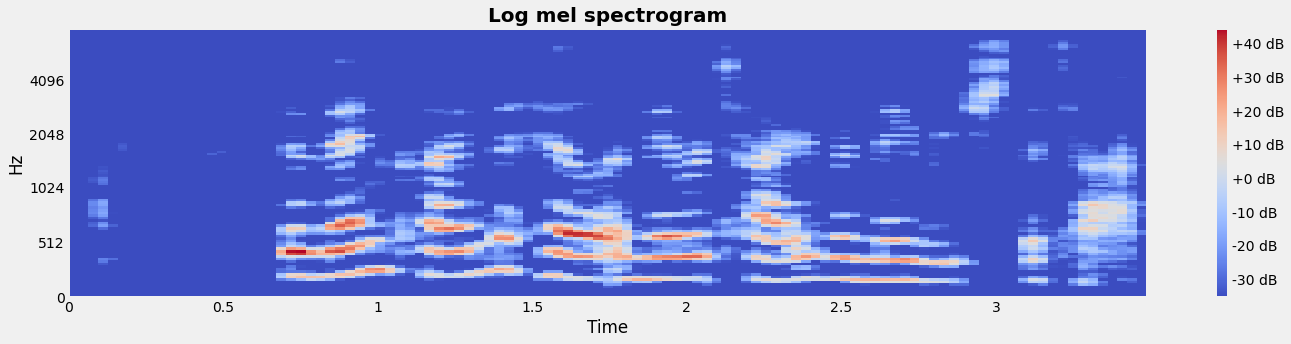

In [21]:
audio_array, sampling_rate = librosa.load(filename, sr=sample_rate) 
mel_spectogram = librosa.feature.melspectrogram(audio_array, sr=sampling_rate, n_mels=128)

# Convert to log scale
log_S = librosa.amplitude_to_db(mel_spectogram)

# Plotting Log Mel-Spectogram
plt.figure(figsize=(20,5))
librosa.display.specshow(log_S, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.title('Log mel spectrogram',fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

### Chroma

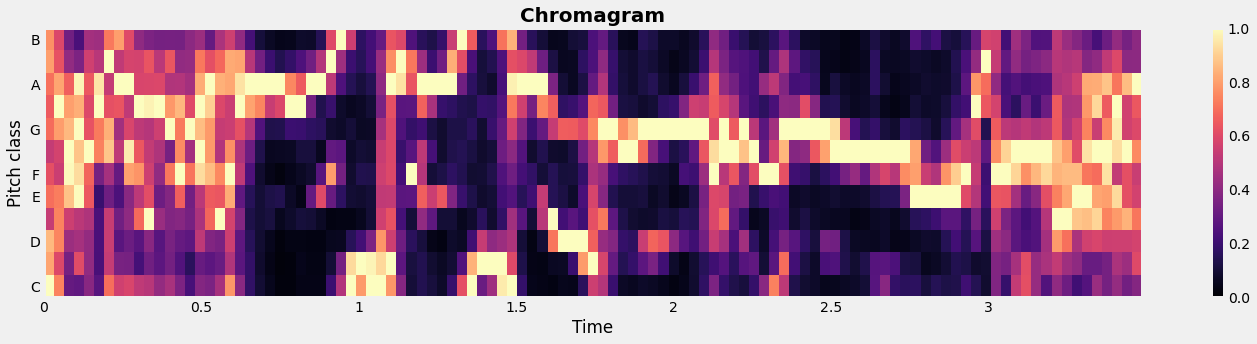

In [22]:
audio_array, sampling_rate = librosa.load(filename, sr=sample_rate)
chroma = librosa.feature.chroma_cqt(y=audio_array, sr=sampling_rate)


plt.figure(figsize=(20,5))

librosa.display.specshow(chroma, sr=sampling_rate, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title('Chromagram',fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.colorbar()
plt.tight_layout()

# Audio Preprocessing

In [23]:
scaler = MinMaxScaler()

In [24]:
# making Directories to store processed data
os.mkdir("./age_data")
os.mkdir("./gender_data")
os.mkdir("./accent_data")

In [25]:
def process_data(file,target_dir):  
    filename = voice_dir +  "/" + file
    y, s = librosa.load(filename, sr=16000)
    y_filt = librosa.effects.preemphasis(y)
    S_preemph = librosa.amplitude_to_db(np.abs(librosa.stft(y_filt)), ref=np.max)
    S_preemph = scaler.fit_transform(S_preemph)
    #librosa.display.specshow(S_preemph, y_axis='log', x_axis='time')
    plt.imshow(S_preemph.T,cmap='plasma')
    plt.axis("off")
    file = file.split("/")[1]
    address = target_dir+"/"+"{}.png".format(file)
    plt.savefig(address)
    plt.close()

### Stroing Gender data

In [26]:
idx = []
cnt_male,cnt_female = 0,0
num_samples = 500
for i in range(train_data.shape[0]):
    if train_data.gender[i] == "male":
        if cnt_male <= num_samples:
            cnt_male +=1
            idx.append(i)
    
    if train_data.gender[i] == "female":
        if cnt_female <= num_samples:
            cnt_female +=1
            idx.append(i)
train_data_gender = train_data.loc[idx]
train_data_gender.reset_index(inplace=True)
train_data_gender.drop("index",axis=1,inplace=True)

In [27]:
for idx in trange(train_data_gender.shape[0]):
    file,gender_group = train_data_gender.filename[idx],train_data_gender.gender[idx]
    path = './gender_data'+"/"+gender_group
    if os.path.isdir(path):
        process_data(file,path)
    else :
        os.mkdir(path)
        process_data(file,path)

100%|██████████| 1002/1002 [09:23<00:00,  1.78it/s]


### Storing Age Data

In [28]:
num_samples = 500
idx = []
cnt_teens,cnt_twenties,cnt_thirties,cnt_fourties,cnt_fifties,cnt_sixties,cnt_seventies = 0,0,0,0,0,0,0
for i in range(train_data.shape[0]):
    if train_data.age[i] == "twenties":
        if cnt_twenties <= num_samples:
            cnt_twenties +=1
            idx.append(i)
    
    if train_data.age[i] == "thirties":
        if cnt_thirties <= num_samples:
            cnt_thirties +=1
            idx.append(i)
    if train_data.age[i] == "fourties":
        if cnt_fourties <= num_samples:
            cnt_fourties +=1
            idx.append(i)
    if train_data.age[i] == "fifties":
        if cnt_fifties <= num_samples:
            cnt_fifties +=1
            idx.append(i)
    if train_data.age[i] == "sixties":
        if cnt_sixties <= num_samples:
            cnt_sixties +=1
            idx.append(i)
    if train_data.age[i] == "seventies":
        if cnt_seventies <= num_samples:
            cnt_seventies +=1
            idx.append(i)
    if train_data.age[i] == "teens":
        if cnt_teens <= num_samples:
            cnt_teens +=1
            idx.append(i)
train_data_age = train_data.loc[idx]
train_data_age.reset_index(inplace=True)
train_data_age.drop("index",axis=1,inplace=True)

In [29]:
for idx in trange(train_data_age.shape[0]):
    file,age_group = train_data_age.filename[idx],train_data_age.age[idx]
    path = './age_data'+"/"+age_group
    if os.path.isdir(path):
        process_data(file,path)
    else :
        os.mkdir(path)
        process_data(file,path)

100%|██████████| 3507/3507 [1:03:46<00:00,  1.09s/it]


### Storing Accent data

In [45]:
num_samples = 200
idx = []
cnt_dict = {"us":0,"england":0,"indian":0,"australia":0,"canada":0,
 "scotland":0,"newzealand":0,"african":0,"ireland":0 }
for i in range(train_data.shape[0]):
    if cnt_dict[train_data.accent[i]] <= num_samples:
        cnt_dict[train_data.accent[i]] +=1
        idx.append(i)
    
    
train_data_accent = train_data.loc[idx]
train_data_accent.reset_index(inplace=True)
train_data_accent.drop("index",axis=1,inplace=True)

In [ ]:
for idx in trange(train_data_accent.shape[0]):
    file,accent_group = train_data_accent.filename[idx],train_data_age.accent[idx]
    path = './accent_data'+"/"+accent_group
    if os.path.isdir(path):
        process_data(file,path)
    else :
        os.mkdir(path)
        process_data(file,path)

 12%|█▏        | 225/1809 [06:32<49:54,  1.89s/it]

# Defining models

In [35]:
def preprocessFn(img):
    return (img-127.0)/127.0

In [36]:
depth = 3
INIT_LR = 0.001
EPOCHS = 10
inputShape=(128,128,3)

data_gen = ImageDataGenerator(validation_split=0.2,preprocessing_function=preprocessFn)

In [6]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def spec_sens(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    sensitivity = TP/(TP+FN)
    # Specificity or true negative rate
    specificity = TN/(TN+FP) 
    
    return sensitivity,specificity

### Dense Architechture

In [7]:
def dense_model(base_model,num_classes):
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [8]:
def define_models(classes):
    num_class = classes
    #Xception
    model_xcep = Xception(include_top=False, weights="imagenet",input_shape =inputShape)
    model_xception = dense_model(model_xcep,num_class)
    model_xception.layers[0].trainable = False

    # InceptionV3
    model_incep = InceptionV3(include_top=False, weights="imagenet",input_shape =inputShape)
    model_inception = dense_model(model_incep,num_class)
    model_inception.layers[0].trainable = False

    #VGG16
    model_1 = VGG16(include_top=False, weights="imagenet",input_shape =inputShape)
    model_vgg1 = dense_model(model_1,num_class)
    model_vgg1.layers[0].trainable = False

    #VGG 19
    model_2 = VGG19(include_top=False, weights="imagenet",input_shape =inputShape)
    model_vgg2 = dense_model(model_2,num_class)
    model_vgg2.layers[0].trainable = False

    #ResNet50
    model_res = ResNet50(include_top=False, weights="imagenet",input_shape =inputShape)
    model_resnet = dense_model(model_res,num_class)
    model_resnet.layers[0].trainable = False

    return [model_xception,model_inception,model_vgg1,model_vgg2,model_resnet]

### Ensemble

In [9]:
def stacking_predictions(models,data):
    # array to store values
    stackValues = None
    for model in models:
        # making predictions for each model
        y_pred = model.predict(data)
        # stack predictions into [rows, members, probabilities]
        if stackValues is None:
            stackValues = y_pred
        else:
            stackValues = np.dstack((stackValues,y_pred))
    # flatten predictions to [rows, members x probabilities]
    stackValues = stackValues.reshape((stackValues.shape[0], stackValues.shape[1]*stackValues.shape[2]))
    return stackValues

In [10]:
def fit_models(models,data):
    # stacked data with ensemble
    stackedValues = stacking_predictions(models,data)
    log_reg = LogisticRegression()
    log_reg.fit(stackedValues,data.labels)
    return log_reg

In [11]:
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacking_predictions(members, inputX)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

# Gender prediction

In [13]:

train_data = data_gen.flow_from_directory(directory = r"./gender_data",
                                                target_size=inputShape[0:2],
                                                batch_size=4,
                                                class_mode='categorical',
                                                shuffle=True,
                                                subset='training')
val_data = data_gen.flow_from_directory(directory = r"./gender_data",
                                                target_size=inputShape[0:2],
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=True,
                                                subset='validation')

Found 802 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [15]:
model_xception,model_inception,model_vgg1,model_vgg2,model_resnet = define_models(2)

83689472/83683744 [==============================] - 44s 1us/step


### Exception Model

In [16]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_xception.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_exception = model_xception.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
201/201 [==============================] - 63s 301ms/step - loss: 1.0259 - accuracy: 0.5206 - recall_score: 0.5206 - precision_score: 0.5206 - f1_score: 0.5206 - val_loss: 1.7527 - val_accuracy: 0.5200 - val_recall_score: 0.5200 - val_precision_score: 0.5200 - val_f1_score: 0.5200
Epoch 2/10
201/201 [==============================] - 59s 292ms/step - loss: 0.8534 - accuracy: 0.5113 - recall_score: 0.5104 - precision_score: 0.5104 - f1_score: 0.5104 - val_loss: 0.8295 - val_accuracy: 0.5550 - val_recall_score: 0.5550 - val_precision_score: 0.5550 - val_f1_score: 0.5550
Epoch 3/10
201/201 [==============================] - 64s 321ms/step - loss: 0.8450 - accuracy: 0.4951 - recall_score: 0.4931 - precision_score: 0.4931 - f1_score: 0.4931 - val_loss: 0.7038 - val_accuracy: 0.5650 - val_recall_score: 0.5650 - val_precision_score: 0.5650 - val_f1_score: 0.5650
Epoch 4/10
201/201 [==============================] - 62s 309ms/step - loss: 0.7436 - accuracy

In [17]:
pred = np.argmax(model_xception.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('xception Test Sensitivity per class: ' ,sensitivity)
print('xception Test Specificity per class: ' , specificity)

xception Test Sensitivity per class:  [0.51685393 0.51351351]
xception Test Specificity per class:  [0.51351351 0.51685393]


### Inception V3

In [18]:

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_inception.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_inception = model_inception.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
201/201 [==============================] - 26s 108ms/step - loss: 0.9911 - accuracy: 0.5377 - recall_score: 0.5377 - precision_score: 0.5377 - f1_score: 0.5377 - val_loss: 1.1338 - val_accuracy: 0.5000 - val_recall_score: 0.5000 - val_precision_score: 0.5000 - val_f1_score: 0.5000
Epoch 2/10
201/201 [==============================] - 22s 110ms/step - loss: 0.8762 - accuracy: 0.5266 - recall_score: 0.5266 - precision_score: 0.5266 - f1_score: 0.5266 - val_loss: 0.9787 - val_accuracy: 0.5500 - val_recall_score: 0.5500 - val_precision_score: 0.5500 - val_f1_score: 0.5500
Epoch 3/10
201/201 [==============================] - 25s 124ms/step - loss: 0.8052 - accuracy: 0.5373 - recall_score: 0.5380 - precision_score: 0.5380 - f1_score: 0.5380 - val_loss: 0.8738 - val_accuracy: 0.5400 - val_recall_score: 0.5400 - val_precision_score: 0.5400 - val_f1_score: 0.5400
Epoch 4/10
201/201 [==============================] - 22s 109ms/step - loss: 0.8143 - accuracy

In [19]:
pred = np.argmax(model_inception.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('Inception Test Sensitivity per class: ' ,sensitivity)
print('Inception Test Specificity per class: ' , specificity)

Inception Test Sensitivity per class:  [0.48818898 0.47945205]
Inception Test Specificity per class:  [0.47945205 0.48818898]


### VGG16

In [20]:

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_vgg1.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_vgg1 = model_vgg1.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
201/201 [==============================] - 59s 284ms/step - loss: 1.0209 - accuracy: 0.5261 - recall_score: 0.5261 - precision_score: 0.5261 - f1_score: 0.5261 - val_loss: 0.9389 - val_accuracy: 0.4500 - val_recall_score: 0.4500 - val_precision_score: 0.4500 - val_f1_score: 0.4500
Epoch 2/10
201/201 [==============================] - 56s 279ms/step - loss: 0.8767 - accuracy: 0.5188 - recall_score: 0.5188 - precision_score: 0.5188 - f1_score: 0.5188 - val_loss: 1.0682 - val_accuracy: 0.5250 - val_recall_score: 0.5250 - val_precision_score: 0.5250 - val_f1_score: 0.5250
Epoch 3/10
201/201 [==============================] - 57s 284ms/step - loss: 0.8274 - accuracy: 0.4986 - recall_score: 0.4986 - precision_score: 0.4986 - f1_score: 0.4986 - val_loss: 1.2408 - val_accuracy: 0.5550 - val_recall_score: 0.5550 - val_precision_score: 0.5550 - val_f1_score: 0.5550
Epoch 4/10
201/201 [==============================] - 57s 282ms/step - loss: 0.7509 - accuracy

In [21]:
pred = np.argmax(model_vgg1.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('VGG16 Test Sensitivity per class: ' ,sensitivity)
print('VGG16 Test Specificity per class: ' , specificity)

VGG16 Test Sensitivity per class:  [0.49193548 0.48684211]
VGG16 Test Specificity per class:  [0.48684211 0.49193548]


### VGG19

In [22]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_vgg2.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_vgg2 = model_vgg2.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
201/201 [==============================] - 71s 345ms/step - loss: 1.0891 - accuracy: 0.4967 - recall_score: 0.4966 - precision_score: 0.4966 - f1_score: 0.4966 - val_loss: 1.0059 - val_accuracy: 0.5100 - val_recall_score: 0.5100 - val_precision_score: 0.5100 - val_f1_score: 0.5100
Epoch 2/10
201/201 [==============================] - 69s 344ms/step - loss: 0.9060 - accuracy: 0.4723 - recall_score: 0.4724 - precision_score: 0.4724 - f1_score: 0.4724 - val_loss: 0.8452 - val_accuracy: 0.5500 - val_recall_score: 0.5500 - val_precision_score: 0.5500 - val_f1_score: 0.5500
Epoch 3/10
201/201 [==============================] - 69s 343ms/step - loss: 0.8227 - accuracy: 0.4765 - recall_score: 0.4764 - precision_score: 0.4764 - f1_score: 0.4764 - val_loss: 0.9108 - val_accuracy: 0.5800 - val_recall_score: 0.5800 - val_precision_score: 0.5800 - val_f1_score: 0.5800
Epoch 4/10
201/201 [==============================] - 69s 344ms/step - loss: 0.7528 - accuracy

In [23]:
pred = np.argmax(model_vgg2.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('VGG19 Test Sensitivity per class: ' ,sensitivity)
print('VGG19 Test Specificity per class: ' , specificity)

VGG19 Test Sensitivity per class:  [0.53719008 0.55696203]
VGG19 Test Specificity per class:  [0.55696203 0.53719008]


### Resnet

In [24]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_resnet.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_resnet = model_resnet.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
201/201 [==============================] - 67s 311ms/step - loss: 1.1353 - accuracy: 0.5080 - recall_score: 0.5065 - precision_score: 0.5065 - f1_score: 0.5065 - val_loss: 1.0538 - val_accuracy: 0.4950 - val_recall_score: 0.4950 - val_precision_score: 0.4950 - val_f1_score: 0.4950
Epoch 2/10
201/201 [==============================] - 59s 293ms/step - loss: 0.8998 - accuracy: 0.5485 - recall_score: 0.5491 - precision_score: 0.5491 - f1_score: 0.5491 - val_loss: 0.9884 - val_accuracy: 0.5650 - val_recall_score: 0.5650 - val_precision_score: 0.5650 - val_f1_score: 0.5650
Epoch 3/10
201/201 [==============================] - 58s 290ms/step - loss: 0.8418 - accuracy: 0.5004 - recall_score: 0.4991 - precision_score: 0.4991 - f1_score: 0.4990 - val_loss: 1.0805 - val_accuracy: 0.6200 - val_recall_score: 0.6200 - val_precision_score: 0.6200 - val_f1_score: 0.6200
Epoch 4/10
201/201 [==============================] - 58s 291ms/step - loss: 0.7828 - accuracy

In [25]:
pred = np.argmax(model_resnet.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('Resnet Test Sensitivity per class: ' ,sensitivity)
print('Resnet Test Specificity per class: ' , specificity)

Resnet Test Sensitivity per class:  [0.5326087  0.52777778]
Resnet Test Specificity per class:  [0.52777778 0.5326087 ]


### Stacking Classifiers

In [26]:
stack_models = [model_xception,model_inception,model_vgg1,model_vgg2,model_resnet]
model = fit_models(stack_models,train_data)
stack_prediction_labels = stacked_prediction(stack_models, model, val_data)
acc = acc_score(val_data.labels, stack_prediction_labels)
recall = rec_score(val_data.labels, stack_prediction_labels,average="weighted")
precision = prec_score(val_data.labels, stack_prediction_labels,average="weighted")
fscore = f_scores(val_data.labels, stack_prediction_labels,average="weighted")
conf_matrix = confusion_matrix(val_data.labels, stack_prediction_labels)
print('Stacked Test Accuracy: %.3f' % acc)
print('Stacked Test Recall: %.3f' % recall)
print('Stacked Test Precision: %.3f' % precision)
print('Stacked Test F1Score : %.3f' % fscore)
print('Stacked Test F1Score : %.3f' % fscore)
sensitivity,specificity = spec_sens(conf_matrix)
print('Stacked Test Sensitivity per class: ' % sensitivity)
print('Stacked Test Specificity per class: ' % specificity)

Stacked Test Accuracy: 0.480
Stacked Test Recall: 0.480
Stacked Test Precision: 0.480
Stacked Test F1Score : 0.480
Stacked Test F1Score : 0.480
Stacked Test Sensitivity per class: 
Stacked Test Specificity per class: 


### Plotting Graphs

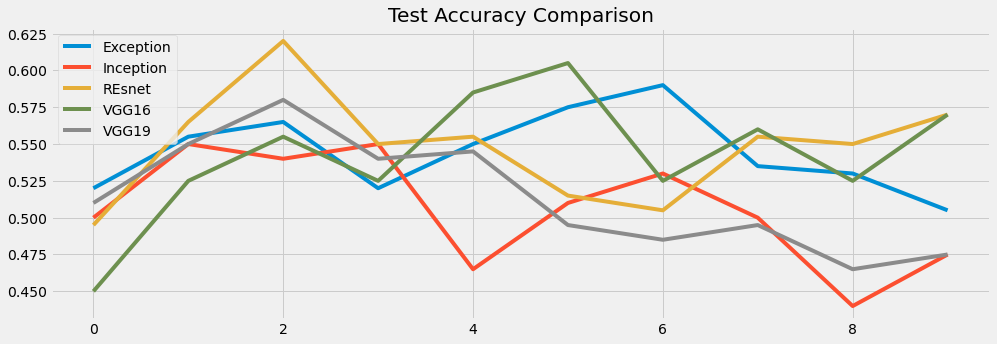

In [27]:
plt.figure(figsize=(15,5))
plt.title("Test Accuracy Comparison")
plt.plot(history_exception.history["val_accuracy"],label = "Exception")
plt.plot(history_inception.history["val_accuracy"],label = "Inception")
plt.plot(history_resnet.history["val_accuracy"],label = "REsnet")
plt.plot(history_vgg1.history["val_accuracy"],label = "VGG16")
plt.plot(history_vgg2.history["val_accuracy"],label = "VGG19")
plt.legend()
plt.show()

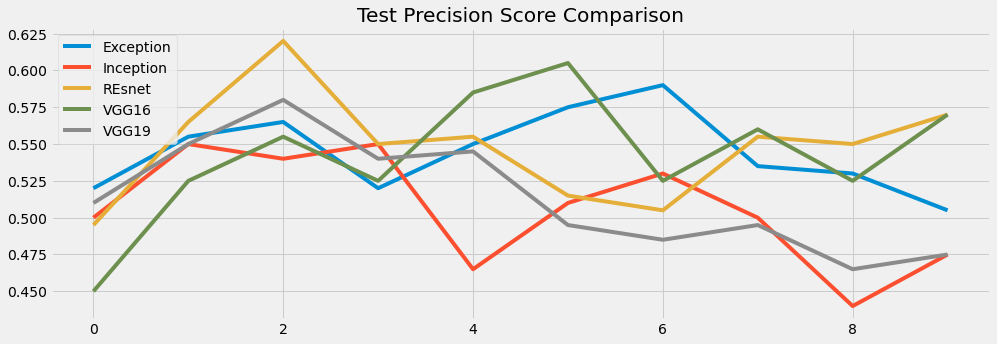

In [28]:
plt.figure(figsize=(15,5))
plt.title("Test Precision Score Comparison")
plt.plot(history_exception.history["val_precision_score"],label = "Exception")
plt.plot(history_inception.history["val_precision_score"],label = "Inception")
plt.plot(history_resnet.history["val_precision_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_precision_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_precision_score"],label = "VGG19")
plt.legend()
plt.show()

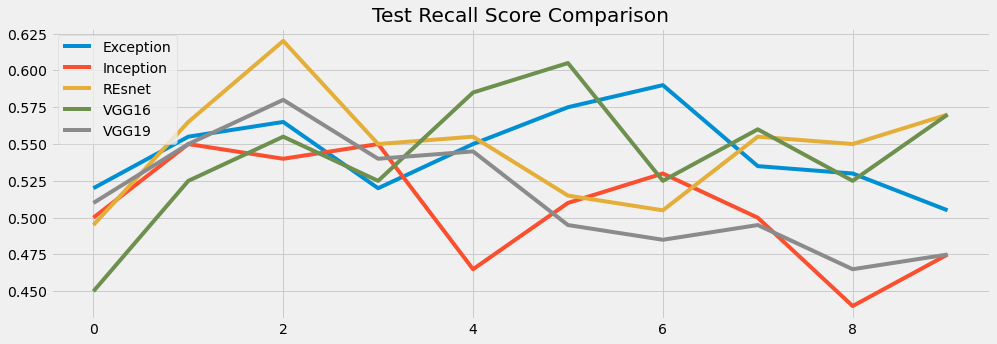

In [29]:
plt.figure(figsize=(15,5))
plt.title("Test Recall Score Comparison")
plt.plot(history_exception.history["val_recall_score"],label = "Exception")
plt.plot(history_inception.history["val_recall_score"],label = "Inception")
plt.plot(history_resnet.history["val_recall_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_recall_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_recall_score"],label = "VGG19")
plt.legend()
plt.show()

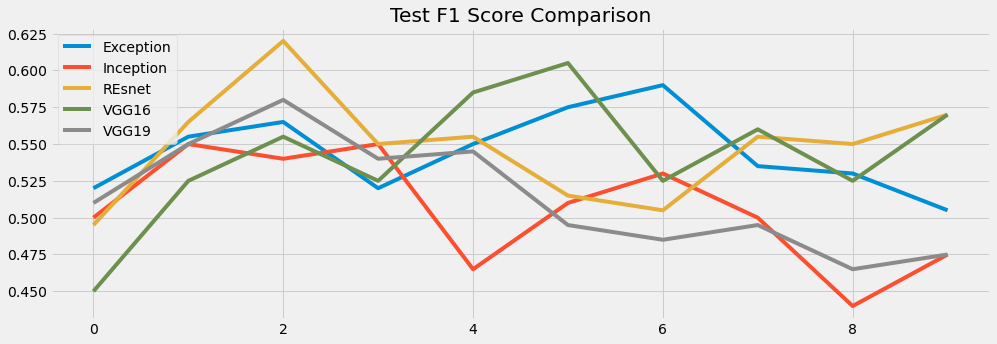

In [30]:
plt.figure(figsize=(15,5))
plt.title("Test F1 Score Comparison")
plt.plot(history_exception.history["val_f1_score"],label = "Exception")
plt.plot(history_inception.history["val_f1_score"],label = "Inception")
plt.plot(history_resnet.history["val_f1_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_f1_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_f1_score"],label = "VGG19")
plt.legend()
plt.show()

# AGE Group Prediction

In [37]:

train_data = data_gen.flow_from_directory(directory = r"./age_data",
                                                target_size=inputShape[0:2],
                                                batch_size=4,
                                                class_mode='categorical',
                                                shuffle=True,
                                                subset='training')
val_data = data_gen.flow_from_directory(directory = r"./age_data",
                                                target_size=inputShape[0:2],
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=True,
                                                subset='validation')

Found 2807 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [38]:
model_xception,model_inception,model_vgg1,model_vgg2,model_resnet = define_models(7)

### Xception

In [40]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_xception.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_xception = model_xception.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
702/702 [==============================] - 217s 304ms/step - loss: 2.1080 - accuracy: 0.1530 - recall_score: 0.0091 - precision_score: 0.0344 - f1_score: 0.0142 - val_loss: 2.2649 - val_accuracy: 0.1857 - val_recall_score: 0.0386 - val_precision_score: 0.0386 - val_f1_score: 0.0386
Epoch 2/10
702/702 [==============================] - 211s 301ms/step - loss: 2.0599 - accuracy: 0.1516 - recall_score: 0.0020 - precision_score: 0.0081 - f1_score: 0.0033 - val_loss: 2.2434 - val_accuracy: 0.1829 - val_recall_score: 0.0271 - val_precision_score: 0.0271 - val_f1_score: 0.0271
Epoch 3/10
702/702 [==============================] - 216s 307ms/step - loss: 2.0115 - accuracy: 0.1599 - recall_score: 0.0000e+00 - precision_score: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 2.2226 - val_accuracy: 0.1957 - val_recall_score: 0.0157 - val_precision_score: 0.0157 - val_f1_score: 0.0157
Epoch 4/10
702/702 [==============================] - 220s 313ms/step - loss: 1

In [41]:
pred = np.argmax(model_xception.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('xception Test Sensitivity per class: ' ,sensitivity)
print('xception Test Specificity per class: ' , specificity)

xception Test Sensitivity per class:  [0.17073171 0.18421053 0.10655738 0.15909091 0.11340206 0.18691589
 0.19811321]
xception Test Specificity per class:  [0.85887709 0.86217949 0.84948097 0.85823171 0.85240464 0.87654321
 0.86700337]


### Inception V3

In [42]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_inception.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_inception= model_inception.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
702/702 [==============================] - 95s 127ms/step - loss: 2.4413 - accuracy: 0.1578 - recall_score: 0.0530 - precision_score: 0.1265 - f1_score: 0.0717 - val_loss: 2.3192 - val_accuracy: 0.1771 - val_recall_score: 0.0371 - val_precision_score: 0.0371 - val_f1_score: 0.0371
Epoch 2/10
702/702 [==============================] - 86s 122ms/step - loss: 2.1233 - accuracy: 0.1711 - recall_score: 0.0111 - precision_score: 0.0411 - f1_score: 0.0173 - val_loss: 2.2668 - val_accuracy: 0.1800 - val_recall_score: 0.0414 - val_precision_score: 0.0414 - val_f1_score: 0.0414
Epoch 3/10
702/702 [==============================] - 90s 129ms/step - loss: 2.0403 - accuracy: 0.1698 - recall_score: 0.0016 - precision_score: 0.0066 - f1_score: 0.0026 - val_loss: 2.2090 - val_accuracy: 0.1800 - val_recall_score: 0.0257 - val_precision_score: 0.0257 - val_f1_score: 0.0257
Epoch 4/10
702/702 [==============================] - 85s 120ms/step - loss: 1.9951 - accuracy

In [43]:
pred = np.argmax(model_inception.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('Inception Test Sensitivity per class: ' ,sensitivity)
print('Inception Test Specificity per class: ' , specificity)

Inception Test Sensitivity per class:  [0.         0.17647059 0.145      0.1547619  0.1640625  0.17894737
 0.20740741]
Inception Test Specificity per class:  [0.85569986 0.85978428 0.858      0.85876623 0.86188811 0.86280992
 0.87256637]


### VGG 16

In [44]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_vgg1.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_vgg1= model_vgg1.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
702/702 [==============================] - 223s 314ms/step - loss: 2.4151 - accuracy: 0.1574 - recall_score: 0.0396 - precision_score: 0.1163 - f1_score: 0.0570 - val_loss: 2.6573 - val_accuracy: 0.1600 - val_recall_score: 0.0614 - val_precision_score: 0.0614 - val_f1_score: 0.0614
Epoch 2/10
702/702 [==============================] - 216s 308ms/step - loss: 2.1310 - accuracy: 0.1545 - recall_score: 0.0099 - precision_score: 0.0346 - f1_score: 0.0152 - val_loss: 2.1288 - val_accuracy: 0.1914 - val_recall_score: 0.0100 - val_precision_score: 0.0100 - val_f1_score: 0.0100
Epoch 3/10
702/702 [==============================] - 211s 301ms/step - loss: 2.0091 - accuracy: 0.1760 - recall_score: 0.0058 - precision_score: 0.0234 - f1_score: 0.0093 - val_loss: 2.1122 - val_accuracy: 0.1814 - val_recall_score: 0.0243 - val_precision_score: 0.0243 - val_f1_score: 0.0243
Epoch 4/10
702/702 [==============================] - 204s 290ms/step - loss: 1.9833 - accu

In [45]:
pred = np.argmax(model_vgg1.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('VGG16 Test Sensitivity per class: ' ,sensitivity)
print('VGG16 Test Specificity per class: ' , specificity)

VGG16 Test Sensitivity per class:  [0.08910891 0.15189873 0.12690355 0.15555556 0.10588235 0.10273973
 0.5       ]
VGG16 Test Specificity per class:  [0.84808013 0.85829308 0.85089463 0.85901639 0.85203252 0.8465704
 0.85816619]


### VGG 19

In [46]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_vgg2.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_vgg2= model_vgg2.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
702/702 [==============================] - 242s 343ms/step - loss: 2.4567 - accuracy: 0.1479 - recall_score: 0.0405 - precision_score: 0.1155 - f1_score: 0.0578 - val_loss: 2.1385 - val_accuracy: 0.1943 - val_recall_score: 0.0143 - val_precision_score: 0.0143 - val_f1_score: 0.0143
Epoch 2/10
702/702 [==============================] - 240s 342ms/step - loss: 2.1296 - accuracy: 0.1544 - recall_score: 0.0071 - precision_score: 0.0237 - f1_score: 0.0107 - val_loss: 2.1439 - val_accuracy: 0.1786 - val_recall_score: 0.0200 - val_precision_score: 0.0200 - val_f1_score: 0.0200
Epoch 3/10
702/702 [==============================] - 241s 343ms/step - loss: 2.0384 - accuracy: 0.1705 - recall_score: 0.0027 - precision_score: 0.0108 - f1_score: 0.0043 - val_loss: 2.0991 - val_accuracy: 0.1929 - val_recall_score: 0.0329 - val_precision_score: 0.0329 - val_f1_score: 0.0329
Epoch 4/10
702/702 [==============================] - 241s 343ms/step - loss: 2.0038 - accu

In [47]:
pred = np.argmax(model_vgg2.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('VGG19 Test Sensitivity per class: ' ,sensitivity)
print('VGG19 Test Specificity per class: ' , specificity)

VGG19 Test Sensitivity per class:  [0.17307692 0.1754386  0.12396694 0.22580645 0.1369863  0.15384615
 0.13253012]
VGG19 Test Specificity per class:  [0.8595679  0.86767486 0.85319516 0.86098655 0.85559567 0.8573508
 0.85393258]


### ResNEt

In [49]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_resnet.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_resnet= model_resnet.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
702/702 [==============================] - 186s 260ms/step - loss: 2.1277 - accuracy: 0.1411 - recall_score: 0.0052 - precision_score: 0.0175 - f1_score: 0.0079 - val_loss: 4.4171 - val_accuracy: 0.1986 - val_recall_score: 0.0343 - val_precision_score: 0.0343 - val_f1_score: 0.0343
Epoch 2/10
702/702 [==============================] - 180s 256ms/step - loss: 2.0418 - accuracy: 0.1528 - recall_score: 0.0014 - precision_score: 0.0057 - f1_score: 0.0023 - val_loss: 4.7751 - val_accuracy: 0.1729 - val_recall_score: 0.0314 - val_precision_score: 0.0314 - val_f1_score: 0.0314
Epoch 3/10
702/702 [==============================] - 180s 257ms/step - loss: 1.9960 - accuracy: 0.1660 - recall_score: 0.0000e+00 - precision_score: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 4.0442 - val_accuracy: 0.1671 - val_recall_score: 0.0114 - val_precision_score: 0.0114 - val_f1_score: 0.0114
Epoch 4/10
702/702 [==============================] - 188s 267ms/step - loss: 1

In [50]:
pred = np.argmax(model_resnet.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('Resnet Test Sensitivity per class: ' ,sensitivity)
print('Resnet Test Specificity per class: ' , specificity)

Resnet Test Sensitivity per class:  [0.33333333        nan 0.12244898 0.17910448 0.29411765 0.14794521
 0.14705882]
Resnet Test Specificity per class:  [0.8579627  0.85714286 0.8517179  0.86572438 0.86090776 0.86268657
 0.85735736]


### Stacking Classifier

In [51]:
stack_models = [model_xception,model_inception,model_vgg1,model_vgg2,model_resnet]

model = fit_models(stack_models,train_data)
stack_prediction_labels = stacked_prediction(stack_models, model, val_data)

acc = acc_score(val_data.labels, stack_prediction_labels)
recall = rec_score(val_data.labels, stack_prediction_labels,average="weighted")
precision = prec_score(val_data.labels, stack_prediction_labels,average="weighted")
fscore = f_scores(val_data.labels, stack_prediction_labels,average="weighted")
conf_matrix = confusion_matrix(val_data.labels, stack_prediction_labels)
print('Stacked Test Accuracy: %.3f' % acc)
print('Stacked Test Recall: %.3f' % recall)
print('Stacked Test Precision: %.3f' % precision)
print('Stacked Test F1Score : %.3f' % fscore)
print('Stacked Test F1Score : %.3f' % fscore)
sensitivity,specificity = spec_sens(conf_matrix)
print('Stacked Test Sensitivity per class: ' % sensitivity)
print('Stacked Test Specificity per class: ' % specificity)

Stacked Test Accuracy: 0.136
Stacked Test Recall: 0.136
Stacked Test Precision: 0.134
Stacked Test F1Score : 0.133
Stacked Test F1Score : 0.133
Stacked Test Sensitivity per class: 
Stacked Test Specificity per class: 


### Plotting Graphs

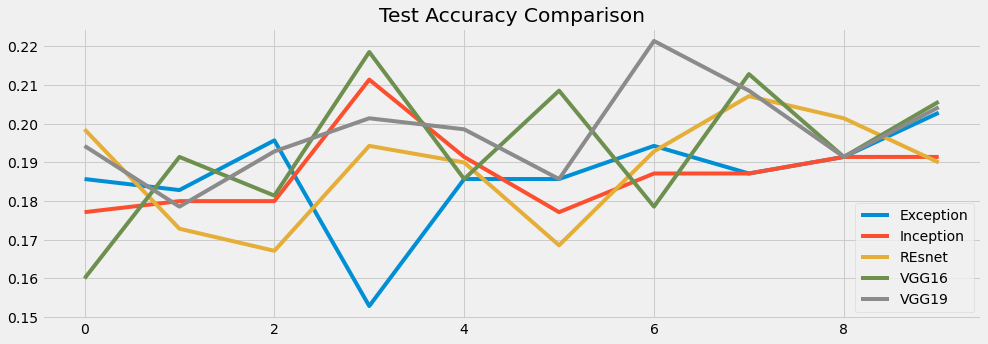

In [52]:
plt.figure(figsize=(15,5))
plt.title("Test Accuracy Comparison")
plt.plot(history_xception.history["val_accuracy"],label = "Exception")
plt.plot(history_inception.history["val_accuracy"],label = "Inception")
plt.plot(history_resnet.history["val_accuracy"],label = "REsnet")
plt.plot(history_vgg1.history["val_accuracy"],label = "VGG16")
plt.plot(history_vgg2.history["val_accuracy"],label = "VGG19")
plt.legend()
plt.show()

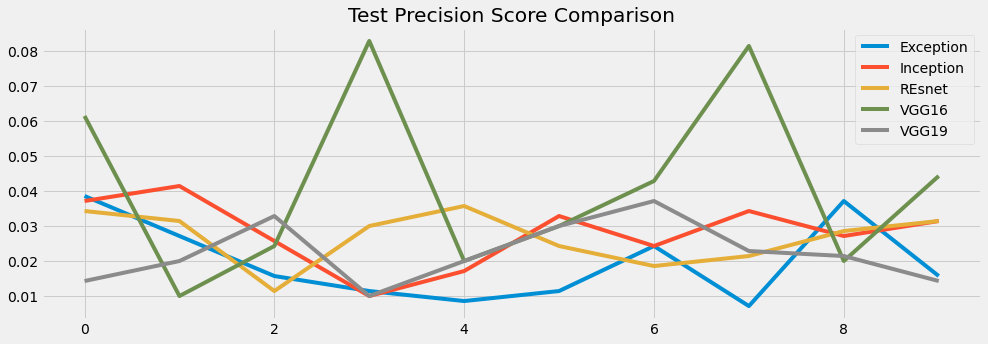

In [53]:
plt.figure(figsize=(15,5))
plt.title("Test Precision Score Comparison")
plt.plot(history_xception.history["val_precision_score"],label = "Exception")
plt.plot(history_inception.history["val_precision_score"],label = "Inception")
plt.plot(history_resnet.history["val_precision_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_precision_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_precision_score"],label = "VGG19")
plt.legend()
plt.show()

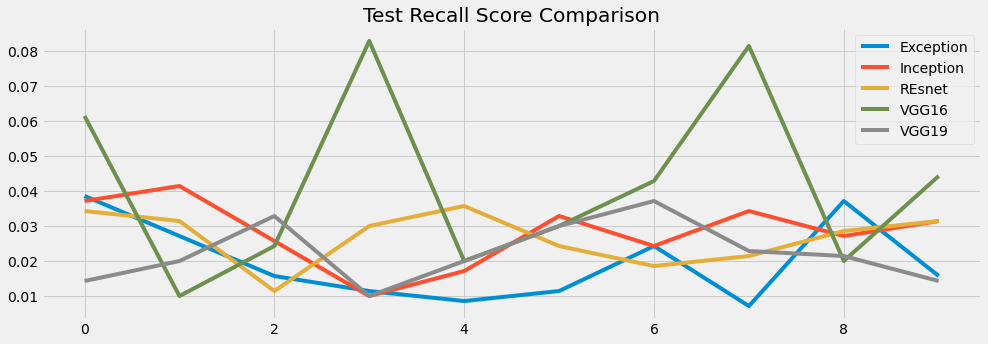

In [54]:
plt.figure(figsize=(15,5))
plt.title("Test Recall Score Comparison")
plt.plot(history_xception.history["val_recall_score"],label = "Exception")
plt.plot(history_inception.history["val_recall_score"],label = "Inception")
plt.plot(history_resnet.history["val_recall_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_recall_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_recall_score"],label = "VGG19")
plt.legend()
plt.show()

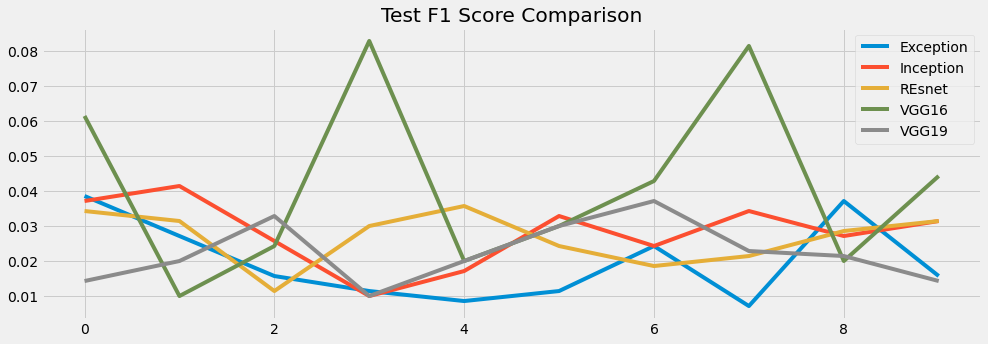

In [55]:
plt.figure(figsize=(15,5))
plt.title("Test F1 Score Comparison")
plt.plot(history_xception.history["val_f1_score"],label = "Exception")
plt.plot(history_inception.history["val_f1_score"],label = "Inception")
plt.plot(history_resnet.history["val_f1_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_f1_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_f1_score"],label = "VGG19")
plt.legend()
plt.show()

# Accent Prediction

In [56]:

train_data = data_gen.flow_from_directory(directory = r"./accent_data",
                                                target_size=inputShape[0:2],
                                                batch_size=4,
                                                class_mode='categorical',
                                                shuffle=True,
                                                subset='training')
val_data = data_gen.flow_from_directory(directory = r"./accent_data",
                                                target_size=inputShape[0:2],
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=True,
                                                subset='validation')

Found 1452 images belonging to 9 classes.
Found 357 images belonging to 9 classes.


In [57]:
model_xception,model_inception,model_vgg1,model_vgg2,model_resnet = define_models(9)

### Xception

In [58]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_xception.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")

history_xception = model_xception.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
363/363 [==============================] - 107s 288ms/step - loss: 2.5486 - accuracy: 0.1861 - recall_score: 0.0527 - precision_score: 0.1520 - f1_score: 0.0759 - val_loss: 2.0973 - val_accuracy: 0.3725 - val_recall_score: 0.1877 - val_precision_score: 0.1877 - val_f1_score: 0.1877
Epoch 2/10
363/363 [==============================] - 98s 269ms/step - loss: 1.8533 - accuracy: 0.4135 - recall_score: 0.2140 - precision_score: 0.4558 - f1_score: 0.2809 - val_loss: 2.4842 - val_accuracy: 0.2773 - val_recall_score: 0.1429 - val_precision_score: 0.1429 - val_f1_score: 0.1429
Epoch 3/10
363/363 [==============================] - 94s 259ms/step - loss: 1.7195 - accuracy: 0.4119 - recall_score: 0.2209 - precision_score: 0.4474 - f1_score: 0.2859 - val_loss: 2.2558 - val_accuracy: 0.3221 - val_recall_score: 0.1989 - val_precision_score: 0.1989 - val_f1_score: 0.1989
Epoch 4/10
363/363 [==============================] - 95s 261ms/step - loss: 1.6802 - accurac

In [59]:
pred = np.argmax(model_xception.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('xception Test Sensitivity per class: ' ,sensitivity)
print('xception Test Specificity per class: ' , specificity)

xception Test Sensitivity per class:  [       nan 0.04545455        nan 0.27586207        nan        nan
 0.                nan 0.48355263]
xception Test Specificity per class:  [0.97759104 0.93134328 0.93557423 0.74695122 0.92997199 0.98879552
 0.98591549 0.98039216 0.56603774]


### Inception V3

In [60]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_inception.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_inception= model_inception.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
363/363 [==============================] - 54s 130ms/step - loss: 2.5047 - accuracy: 0.2198 - recall_score: 0.0735 - precision_score: 0.2213 - f1_score: 0.1072 - val_loss: 2.3896 - val_accuracy: 0.3277 - val_recall_score: 0.2213 - val_precision_score: 0.2213 - val_f1_score: 0.2213
Epoch 2/10
363/363 [==============================] - 47s 130ms/step - loss: 1.8360 - accuracy: 0.3668 - recall_score: 0.1979 - precision_score: 0.4495 - f1_score: 0.2648 - val_loss: 1.8781 - val_accuracy: 0.3950 - val_recall_score: 0.2129 - val_precision_score: 0.2129 - val_f1_score: 0.2129
Epoch 3/10
363/363 [==============================] - 46s 126ms/step - loss: 1.7110 - accuracy: 0.4085 - recall_score: 0.2157 - precision_score: 0.4668 - f1_score: 0.2849 - val_loss: 1.8297 - val_accuracy: 0.3810 - val_recall_score: 0.2353 - val_precision_score: 0.2353 - val_f1_score: 0.2353
Epoch 4/10
363/363 [==============================] - 44s 122ms/step - loss: 1.7026 - accuracy

In [61]:
pred = np.argmax(model_inception.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('Inception Test Sensitivity per class: ' ,sensitivity)
print('Inception Test Specificity per class: ' , specificity)

Inception Test Sensitivity per class:  [       nan        nan 0.         0.21333333        nan        nan
        nan        nan 0.45787546]
Inception Test Specificity per class:  [0.97759104 0.93277311 0.93390805 0.73404255 0.92997199 0.98879552
 0.9859944  0.98039216 0.46428571]


### VGG16

In [62]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_vgg1.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_vgg1= model_vgg1.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
363/363 [==============================] - 99s 268ms/step - loss: 2.4977 - accuracy: 0.1952 - recall_score: 0.0619 - precision_score: 0.1767 - f1_score: 0.0885 - val_loss: 1.6636 - val_accuracy: 0.4594 - val_recall_score: 0.0840 - val_precision_score: 0.0840 - val_f1_score: 0.0840
Epoch 2/10
363/363 [==============================] - 97s 267ms/step - loss: 1.8265 - accuracy: 0.3894 - recall_score: 0.1894 - precision_score: 0.4031 - f1_score: 0.2490 - val_loss: 1.8445 - val_accuracy: 0.3473 - val_recall_score: 0.1849 - val_precision_score: 0.1849 - val_f1_score: 0.1849
Epoch 3/10
363/363 [==============================] - 96s 266ms/step - loss: 1.6572 - accuracy: 0.4310 - recall_score: 0.2408 - precision_score: 0.4937 - f1_score: 0.3140 - val_loss: 1.6693 - val_accuracy: 0.4314 - val_recall_score: 0.2325 - val_precision_score: 0.2325 - val_f1_score: 0.2325
Epoch 4/10
363/363 [==============================] - 96s 265ms/step - loss: 1.6454 - accuracy

In [63]:
pred = np.argmax(model_vgg1.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('VGG16 Test Sensitivity per class: ' ,sensitivity)
print('VGG16 Test Specificity per class: ' , specificity)

VGG16 Test Sensitivity per class:  [       nan 0.         0.07692308 0.2745098  0.                nan
        nan        nan 0.45922747]
VGG16 Test Specificity per class:  [0.97759104 0.93123209 0.93604651 0.75294118 0.92977528 0.98879552
 0.9859944  0.98039216 0.49193548]


### VGG19

In [64]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_vgg2.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_vgg2= model_vgg2.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
363/363 [==============================] - 119s 323ms/step - loss: 2.5132 - accuracy: 0.2114 - recall_score: 0.0642 - precision_score: 0.1802 - f1_score: 0.0914 - val_loss: 2.1464 - val_accuracy: 0.2997 - val_recall_score: 0.0672 - val_precision_score: 0.0672 - val_f1_score: 0.0672
Epoch 2/10
363/363 [==============================] - 116s 321ms/step - loss: 1.8434 - accuracy: 0.3992 - recall_score: 0.1789 - precision_score: 0.3927 - f1_score: 0.2379 - val_loss: 1.7994 - val_accuracy: 0.3866 - val_recall_score: 0.2157 - val_precision_score: 0.2157 - val_f1_score: 0.2157
Epoch 3/10
363/363 [==============================] - 116s 321ms/step - loss: 1.7318 - accuracy: 0.4183 - recall_score: 0.2237 - precision_score: 0.4478 - f1_score: 0.2893 - val_loss: 2.0700 - val_accuracy: 0.3137 - val_recall_score: 0.1821 - val_precision_score: 0.1821 - val_f1_score: 0.1821
Epoch 4/10
363/363 [==============================] - 116s 321ms/step - loss: 1.6263 - accu

In [65]:
pred = np.argmax(model_vgg2.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('VGG19 Test Sensitivity per class: ' ,sensitivity)
print('VGG19 Test Specificity per class: ' , specificity)

VGG19 Test Sensitivity per class:  [0.                nan        nan 0.26388889        nan        nan
 0.         0.04545455 0.47933884]
VGG19 Test Specificity per class:  [0.97633136 0.93277311 0.93557423 0.74736842 0.92997199 0.98879552
 0.98591549 0.98208955 0.53043478]


### ResNet

In [66]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model_resnet.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy",recall_score,precision_score,f1_score])
# train the network
print("[INFO] training network...")
history_resnet= model_resnet.fit(train_data,epochs=EPOCHS,validation_data = val_data)

[INFO] training network...
Epoch 1/10
363/363 [==============================] - 108s 287ms/step - loss: 2.5015 - accuracy: 0.1797 - recall_score: 0.0653 - precision_score: 0.1727 - f1_score: 0.0914 - val_loss: 1.9810 - val_accuracy: 0.3782 - val_recall_score: 0.1793 - val_precision_score: 0.1793 - val_f1_score: 0.1793
Epoch 2/10
363/363 [==============================] - 103s 283ms/step - loss: 1.8422 - accuracy: 0.3877 - recall_score: 0.2097 - precision_score: 0.4393 - f1_score: 0.2743 - val_loss: 1.7876 - val_accuracy: 0.3838 - val_recall_score: 0.1373 - val_precision_score: 0.1373 - val_f1_score: 0.1373
Epoch 3/10
363/363 [==============================] - 99s 272ms/step - loss: 1.7204 - accuracy: 0.4234 - recall_score: 0.2026 - precision_score: 0.4823 - f1_score: 0.2755 - val_loss: 2.0689 - val_accuracy: 0.4146 - val_recall_score: 0.2661 - val_precision_score: 0.2661 - val_f1_score: 0.2661
Epoch 4/10
363/363 [==============================] - 98s 270ms/step - loss: 1.6912 - accura

In [67]:
pred = np.argmax(model_resnet.predict(val_data),axis=1)
conf_matrix = confusion_matrix(pred,val_data.labels)
sensitivity,specificity = spec_sens(conf_matrix)
print('Resnet Test Sensitivity per class: ' ,sensitivity)
print('Resnet Test Specificity per class: ' , specificity)

Resnet Test Sensitivity per class:  [       nan 0.                nan 0.27777778        nan 0.
        nan        nan 0.48367953]
Resnet Test Specificity per class:  [0.97759104 0.93258427 0.93557423 0.74631268 0.92997199 0.98876404
 0.9859944  0.98039216 0.65      ]


### Stacking Ensemble

In [68]:
stack_models = [model_xception,model_inception,model_vgg1,model_vgg2,model_resnet]
model = fit_models(stack_models,train_data)
stack_prediction_labels = stacked_prediction(stack_models, model, val_data)

acc = acc_score(val_data.labels, stack_prediction_labels)
recall = rec_score(val_data.labels, stack_prediction_labels,average="weighted")
precision = prec_score(val_data.labels, stack_prediction_labels,average="weighted")
fscore = f_scores(val_data.labels, stack_prediction_labels,average="weighted")
conf_matrix = confusion_matrix(val_data.labels, stack_prediction_labels)
print('Stacked Test Accuracy: %.3f' % acc)
print('Stacked Test Recall: %.3f' % recall)
print('Stacked Test Precision: %.3f' % precision)
print('Stacked Test F1Score : %.3f' % fscore)
print('Stacked Test F1Score : %.3f' % fscore)
sensitivity,specificity = spec_sens(conf_matrix)
print('Stacked Test Sensitivity per class: ' % sensitivity)
print('Stacked Test Specificity per class: ' % specificity)

Stacked Test Accuracy: 0.476
Stacked Test Recall: 0.476
Stacked Test Precision: 0.227
Stacked Test F1Score : 0.307
Stacked Test F1Score : 0.307
Stacked Test Sensitivity per class: 
Stacked Test Specificity per class: 


### Plotting Graphs

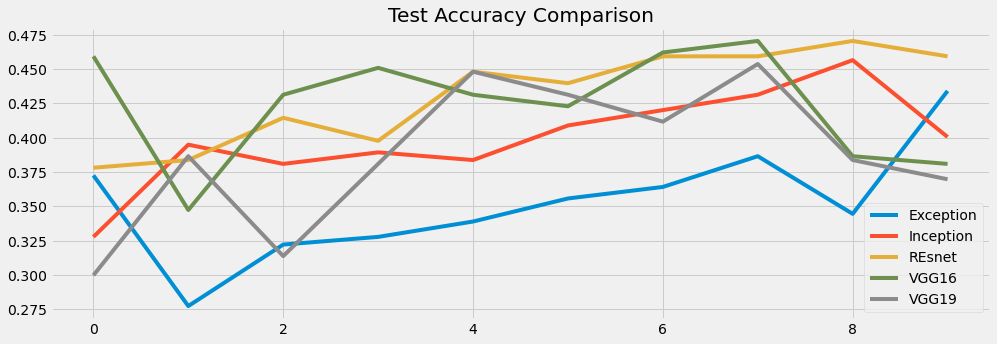

In [69]:
plt.figure(figsize=(15,5))
plt.title("Test Accuracy Comparison")
plt.plot(history_xception.history["val_accuracy"],label = "Exception")
plt.plot(history_inception.history["val_accuracy"],label = "Inception")
plt.plot(history_resnet.history["val_accuracy"],label = "REsnet")
plt.plot(history_vgg1.history["val_accuracy"],label = "VGG16")
plt.plot(history_vgg2.history["val_accuracy"],label = "VGG19")
plt.legend()
plt.show()

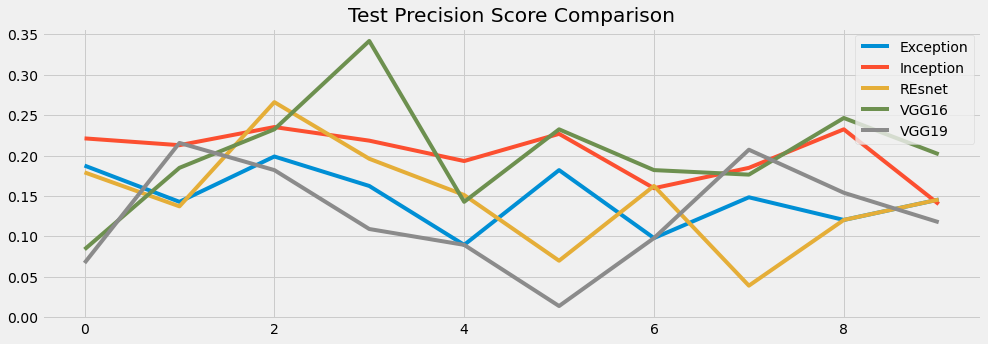

In [70]:
plt.figure(figsize=(15,5))
plt.title("Test Precision Score Comparison")
plt.plot(history_xception.history["val_precision_score"],label = "Exception")
plt.plot(history_inception.history["val_precision_score"],label = "Inception")
plt.plot(history_resnet.history["val_precision_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_precision_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_precision_score"],label = "VGG19")
plt.legend()
plt.show()

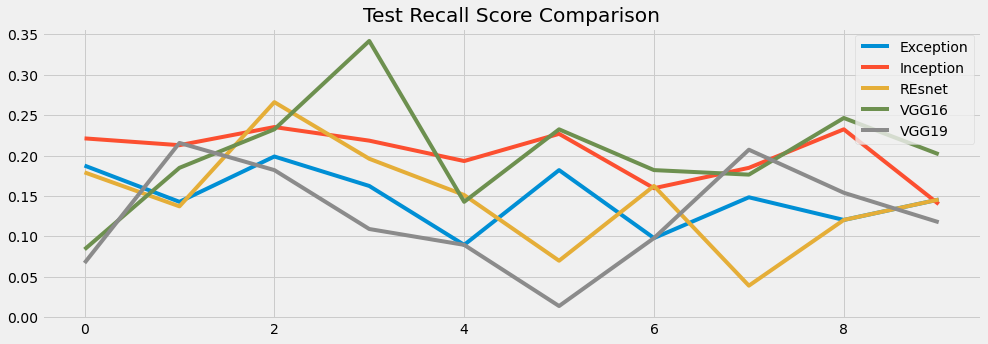

In [71]:
plt.figure(figsize=(15,5))
plt.title("Test Recall Score Comparison")
plt.plot(history_xception.history["val_recall_score"],label = "Exception")
plt.plot(history_inception.history["val_recall_score"],label = "Inception")
plt.plot(history_resnet.history["val_recall_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_recall_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_recall_score"],label = "VGG19")
plt.legend()
plt.show()

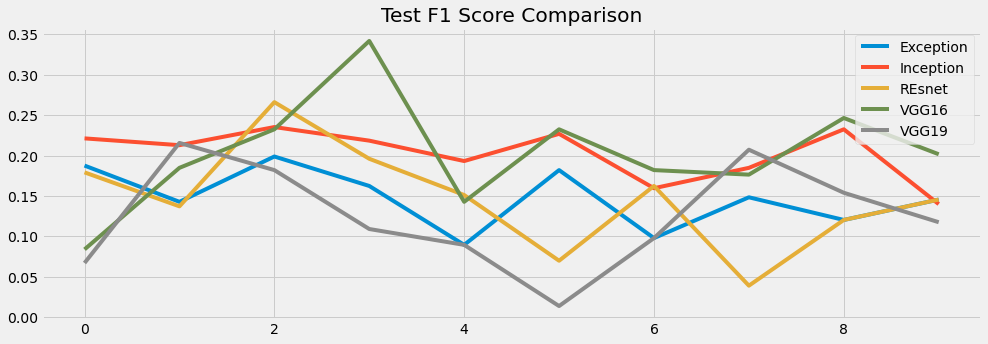

In [72]:
plt.figure(figsize=(15,5))
plt.title("Test F1 Score Comparison")
plt.plot(history_xception.history["val_f1_score"],label = "Exception")
plt.plot(history_inception.history["val_f1_score"],label = "Inception")
plt.plot(history_resnet.history["val_f1_score"],label = "REsnet")
plt.plot(history_vgg1.history["val_f1_score"],label = "VGG16")
plt.plot(history_vgg2.history["val_f1_score"],label = "VGG19")
plt.legend()
plt.show()